try with series column and three classes and ['BallFault', 'InnerFault', 'outerFault'] and two features speed , and vibration with accuracy of 86% with dropouts rows of same records in speed and vibration. now i make take equal distribution of classes with diffrent batch_size 
#https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/


In [27]:

#moving avg window
#datasetdir = "../datasets/allfaultdatasetfiltered13.csv"
figuredir = "../figures/MLPv13gr/"

import os

# You should change 'test' to your preferred folder.
#CHECK_FOLDER = os.path.isdir(datasetdir)

# You should change 'test' to your preferred folder.
CHECK_FOLDER = os.path.isdir(figuredir)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(figuredir)
    print("created folder : ", figuredir)

else:
    print(figuredir, "folder already exists.")


../figures/MLPv13gr/ folder already exists.


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
plt.rcParams["figure.figsize"] = (15,8)

In [29]:
#df = pd.read_csv("../datasets/allfaultdatasetfiltered13.csv")
## to rename outerfault 
df = pd.read_csv("../datasets/allfaultdatasetfiltered13.csv", index_col ="class" )
"""Droping Series Column which is no longer required 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

df.drop(['B', 'C'], axis=1)

also rearrange columns order
df = df[['speed','vibration','Faults']]

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
#df.rename(columns={"A": "a", "B": "c"})
"""
df = df.drop(['series'], axis=1)
df = df.rename(index={'BallFault':'Ball'})
df = df.rename(index={'InnerFault':'Innerrace'})
df = df.rename(index={'outerFault':'Outerrace'})
df = df.reset_index()
df = df.rename(columns  ={'class':'Faults'})
df = df[['speed','vibration','Faults']]
df.head() , df['Faults'].unique()


(      speed  vibration Faults
 0  4.217042   0.003062   Ball
 1  4.219672   0.004049   Ball
 2  4.221645   0.001418   Ball
 3  0.036346  -0.002199   Ball
 4  0.036017  -0.003515   Ball,
 array(['Ball', 'Innerrace', 'Outerrace'], dtype=object))

In [30]:
#Re ordering column

#df = df[["speed", "vibration", "series", "class"]]

In [31]:
df.info

<bound method DataFrame.info of             speed  vibration     Faults
0        4.217042   0.003062       Ball
1        4.219672   0.004049       Ball
2        4.221645   0.001418       Ball
3        0.036346  -0.002199       Ball
4        0.036017  -0.003515       Ball
...           ...        ...        ...
5667608  4.202576  -0.004830  Outerrace
5667609  4.198959  -0.003515  Outerrace
5667610  4.279838  -0.002857  Outerrace
5667611  0.037332  -0.006146  Outerrace
5667612  0.037661  -0.009105  Outerrace

[5667613 rows x 3 columns]>

In [32]:
#healthy = healthy.rename(columns={"vsH": "speed", "vbH": "vibration"})

In [33]:
# it change style and colour for graph 
#from yellowbrick.classifier import ClassificationReport
## OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)
plt.rcParams['agg.path.chunksize'] = 100000

sns.countplot(x = 'Faults', data=df )

# to save plots in high ddefinition 
#plt.savefig("../figures/class_distribution_beforedropouts.png")
plt.ylabel("Records")
plt.savefig("../figures/class_distribution_beforedropouts.png", bbox_inches='tight', dpi=1200)
plt.show()

In [34]:
#df['Faults'].unique()

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="speed", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10" , alpha = 0.2)

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Speed")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration vs speed.png", bbox_inches='tight', dpi=600)

sns.boxplot(x = 'Faults',y = 'vibration', data=df.reset_index())

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="index", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10")

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Timestamp")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration_beforedropouts.png", bbox_inches='tight', dpi=1200)

In [35]:
df = df.drop_duplicates(subset = ["speed", 'vibration'])

print(df)

            speed  vibration     Faults
0        4.217042   0.003062       Ball
1        4.219672   0.004049       Ball
2        4.221645   0.001418       Ball
3        0.036346  -0.002199       Ball
4        0.036017  -0.003515       Ball
...           ...        ...        ...
5667456  4.151615  -0.016340  Outerrace
5667459  2.739196  -0.009105  Outerrace
5667542  3.131096  -0.001213  Outerrace
5667560  1.329083  -0.000555  Outerrace
5667578  0.155362   0.001747  Outerrace

[757558 rows x 3 columns]


sns.countplot(x = 'Faults', data=df)

# to save plots in high ddefinition 
#plt.savefig("../figures/class_distribution_beforedropouts.png")
plt.ylabel("Records")
plt.savefig(figuredir + "class_distribution_afterdropouts.png", bbox_inches='tight', dpi=600)
plt.show()

In [36]:
#['BallFault', 'InnerFault', 'outerFault']

BallFaultlenght = len(df[df['Faults']=='Ball'])
InnerFaultlenght = len(df[df['Faults']=='Innerrace'])
outerFaultlenght = len(df[df['Faults']=='Outerrace'])


#BallFaultlenght = 20000
#InnerFaultlenght = 20000 
#outerFaultlenght = 20000

print(BallFaultlenght)
print(InnerFaultlenght)
print(outerFaultlenght)

203913
451728
101917


In [37]:

newBallFault = df[df['Faults']=='Ball'].iloc[0:outerFaultlenght]
newInnerFault = df[df['Faults']=='Innerrace'].iloc[0:outerFaultlenght]
newouterFault = df[df['Faults']=='Outerrace'].iloc[0:outerFaultlenght]


newBallFault , newInnerFault , newouterFault

(           speed  vibration Faults
 0       4.217042   0.003062   Ball
 1       4.219672   0.004049   Ball
 2       4.221645   0.001418   Ball
 3       0.036346  -0.002199   Ball
 4       0.036017  -0.003515   Ball
 ...          ...        ...    ...
 722641  4.187452  -0.021273   Ball
 722642  4.264386  -0.022588   Ball
 722651  4.092436  -0.007790   Ball
 722681  4.127286  -0.019957   Ball
 722682  4.229864  -0.020944   Ball
 
 [101917 rows x 3 columns],
             speed  vibration     Faults
 1889180  0.037990   0.248711  Innerrace
 1889181  0.037661   0.249040  Innerrace
 1889182  0.037990   0.248382  Innerrace
 1889183  0.037661   0.250355  Innerrace
 1889184  0.037332   0.251013  Innerrace
 ...           ...        ...        ...
 2223245  4.086847   0.223390  Innerrace
 2223248  4.106573   0.223719  Innerrace
 2223250  1.064749   0.230624  Innerrace
 2223257  4.159177   0.201357  Innerrace
 2223259  4.242358   0.189847  Innerrace
 
 [101917 rows x 3 columns],
             spe

In [38]:
new_df = newBallFault
new_df = new_df.append(newInnerFault)
new_df = new_df.append(newouterFault)


new_df.tail

<bound method NDFrame.tail of             speed  vibration     Faults
0        4.217042   0.003062       Ball
1        4.219672   0.004049       Ball
2        4.221645   0.001418       Ball
3        0.036346  -0.002199       Ball
4        0.036017  -0.003515       Ball
...           ...        ...        ...
5667456  4.151615  -0.016340  Outerrace
5667459  2.739196  -0.009105  Outerrace
5667542  3.131096  -0.001213  Outerrace
5667560  1.329083  -0.000555  Outerrace
5667578  0.155362   0.001747  Outerrace

[305751 rows x 3 columns]>

In [39]:
df = new_df

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="speed", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10")

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Speed")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration vs speed afterdropouts.png", bbox_inches='tight', dpi=1200)

#df['vibration'].plot(color='b',figsize = (8,8))

g = sns.lineplot(x="index", y="vibration",hue= 'Faults',
                data=df.reset_index(), palette="tab10")

plt.legend(loc=2)
plt.ylabel("Vibration")
plt.xlabel("Timestamp")
plt.tick_params(axis='both',labelsize=14)

g.legend(loc= 'upper right')
g.legend_.set_title('Faults')

plt.savefig("../figures/vibration_afterdropouts.png", bbox_inches='tight', dpi=1200)

sns.countplot(x = 'Faults', data=df)

# to save plots in high ddefinition 
#plt.savefig("../figures/class_distribution_beforedropouts.png")
plt.ylabel('Records')
plt.savefig(figuredir + "class_distribution_after_equal_distribution.png", bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
class2idx = {
    "Ball":0,
    "Innerrace":1,
    "Outerrace":2

}

idx2class = {v: k for k, v in class2idx.items()}

#df['Faults'].replace(class2idx, inplace=True)
#df['Faults'].unique()

In [40]:
# droping series
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X.head() , y.head()

(      speed  vibration
 0  4.217042   0.003062
 1  4.219672   0.004049
 2  4.221645   0.001418
 3  0.036346  -0.002199
 4  0.036017  -0.003515,
 0    Ball
 1    Ball
 2    Ball
 3    Ball
 4    Ball
 Name: Faults, dtype: object)

In [41]:
y.unique() , len(y.unique())

(array(['Ball', 'Innerrace', 'Outerrace'], dtype=object), 3)

In [42]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV

In [50]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.33)

In [51]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [52]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(150,100,50),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam')

mlp_clf.fit(trainX_scaled, trainY)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300)

In [53]:
y_pred = mlp_clf.predict(testX_scaled)

print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))

Accuracy: 0.87


confusion_matrix_df = pd.DataFrame(confusion_matrix(mlp_clf, testX_scaled, testY)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

target_names = { k for k, v in class2idx.items()}
f1score = classification_report(testY, y_pred, target_names=target_names)
print(f1score)

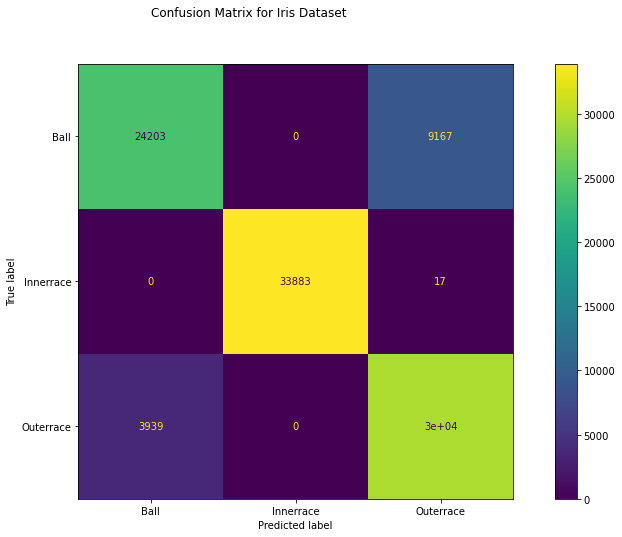

In [54]:
fig = plot_confusion_matrix(mlp_clf, testX_scaled, testY, display_labels=mlp_clf.classes_)
fig.figure_.suptitle("Confusion Matrix for Iris Dataset")
plt.show()

In [55]:
print(classification_report(testY, y_pred))

              precision    recall  f1-score   support

        Ball       0.86      0.73      0.79     33370
   Innerrace       1.00      1.00      1.00     33900
   Outerrace       0.76      0.88      0.82     33628

    accuracy                           0.87    100898
   macro avg       0.87      0.87      0.87    100898
weighted avg       0.87      0.87      0.87    100898



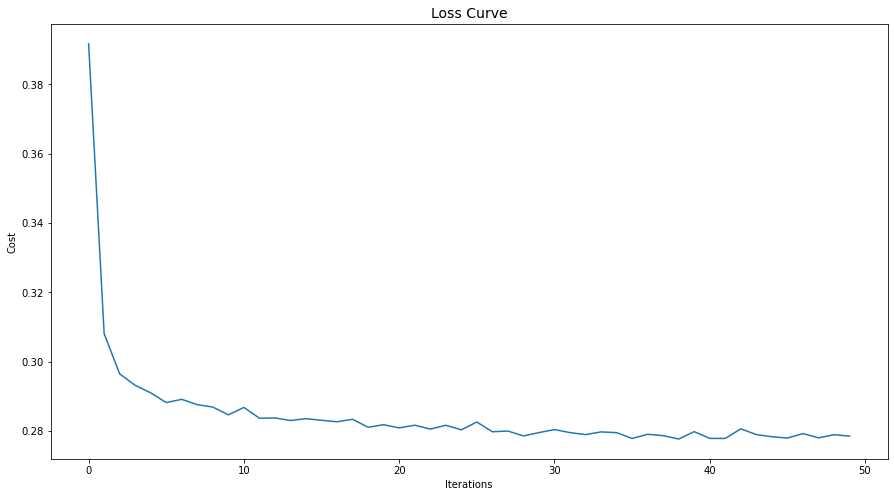

In [56]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [57]:
param_grid = {
    'hidden_layer_sizes': [(512,128,64),(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100, 150],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.0007, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [58]:
grid = GridSearchCV(mlp_clf, param_grid, n_jobs= -1, cv=5)
grid.fit(trainX_scaled, trainY)

print(grid.best_params_) 

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'adam'}


In [59]:
grid_predictions = grid.predict(testX_scaled) 

print('Accuracy: {:.2f}'.format(accuracy_score(testY, grid_predictions)))

Accuracy: 0.86


## new test 

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.33)

In [60]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [61]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,50,30),
                        max_iter = 100,activation = 'relu',
                        solver = 'adam',alpha= 0.0001 , learning_rate= 'adaptive'
                       )

mlp_clf.fit(trainX_scaled, trainY)

MLPClassifier(hidden_layer_sizes=(100, 50, 30), learning_rate='adaptive',
              max_iter=100)

In [62]:
y_pred = mlp_clf.predict(testX_scaled)

print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))

Accuracy: 0.87


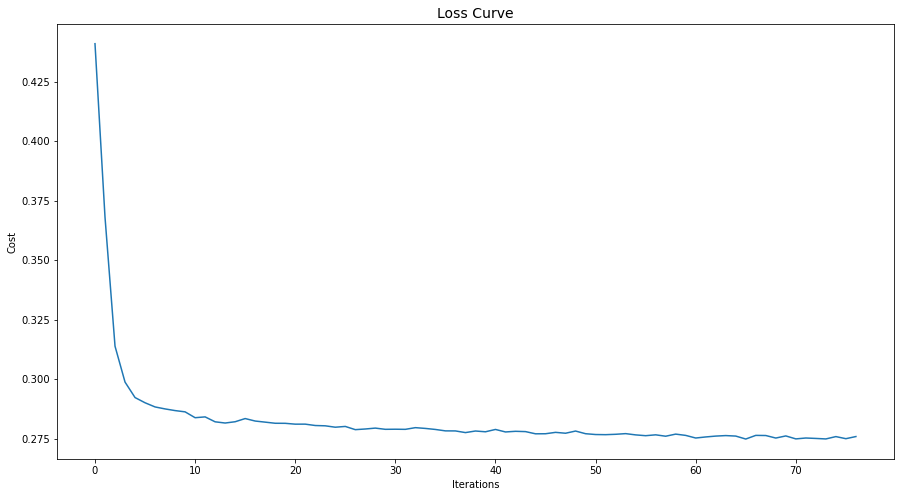

In [65]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()


In [76]:
class2idx = {
    "Ball":0,
    "Innerrace":1,
    "Outerrace":2

}

idx2class = {v: k for k, v in class2idx.items()}

#df['Faults'].replace(class2idx, inplace=True)
#df['Faults'].unique()

In [79]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(testY, y_pred)).rename(columns=idx2class, index=idx2class)
target_names = { k for k, v in class2idx.items()}
f1score = classification_report(testY, y_pred, target_names=target_names)
print(f1score)

              precision    recall  f1-score   support

   Innerrace       0.85      0.74      0.79     33370
        Ball       1.00      1.00      1.00     33900
   Outerrace       0.77      0.87      0.82     33628

    accuracy                           0.87    100898
   macro avg       0.87      0.87      0.87    100898
weighted avg       0.87      0.87      0.87    100898



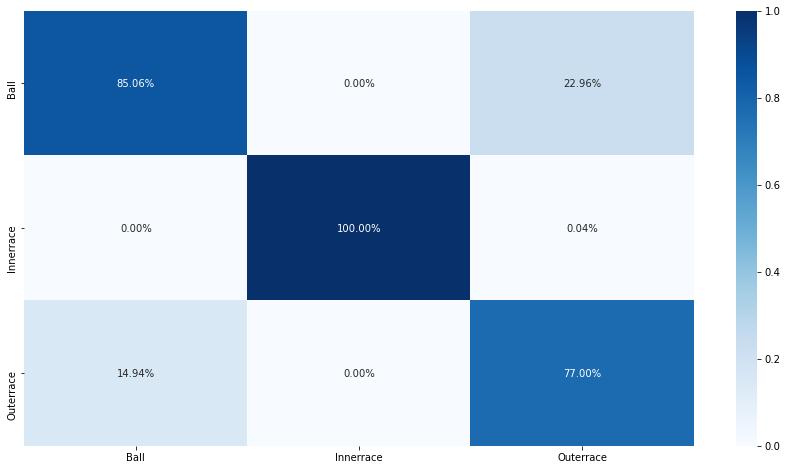

In [81]:
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues')
#plt.title('Confusion Matrix')

#,  ax=axes[0]).set_title('Train-Val Accuracy/Epoch'


plt.savefig(figuredir + "confusion_matrix1.png", bbox_inches='tight', dpi=600)
plt.show()


## new test 

In [83]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2)

In [84]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [85]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,50,30),
                        max_iter = 100,activation = 'relu',
                        solver = 'adam',alpha= 0.0001 , learning_rate= 'adaptive'
                       )

mlp_clf.fit(trainX_scaled, trainY)

MLPClassifier(hidden_layer_sizes=(100, 50, 30), learning_rate='adaptive',
              max_iter=100)

In [86]:
y_pred = mlp_clf.predict(testX_scaled)

print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))

Accuracy: 0.87


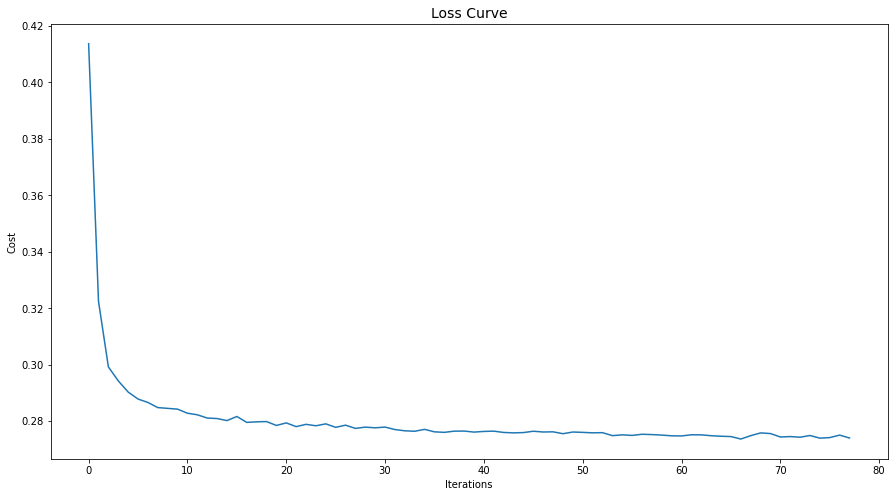

In [87]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()


In [88]:
class2idx = {
    "Ball":0,
    "Innerrace":1,
    "Outerrace":2

}

idx2class = {v: k for k, v in class2idx.items()}

#df['Faults'].replace(class2idx, inplace=True)
#df['Faults'].unique()

In [89]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(testY, y_pred)).rename(columns=idx2class, index=idx2class)
target_names = { k for k, v in class2idx.items()}
f1score = classification_report(testY, y_pred, target_names=target_names)
print(f1score)

              precision    recall  f1-score   support

   Innerrace       0.85      0.73      0.79     20452
        Ball       1.00      1.00      1.00     20522
   Outerrace       0.76      0.87      0.81     20177

    accuracy                           0.87     61151
   macro avg       0.87      0.87      0.87     61151
weighted avg       0.87      0.87      0.87     61151



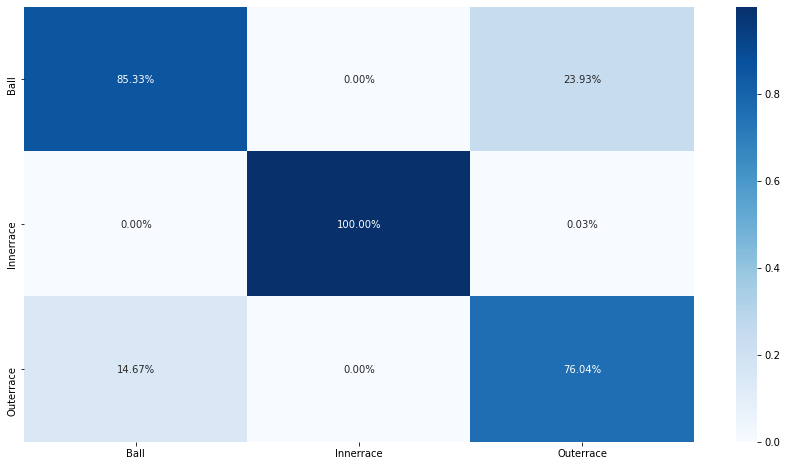

In [90]:
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues')
#plt.title('Confusion Matrix')

#,  ax=axes[0]).set_title('Train-Val Accuracy/Epoch'


plt.savefig(figuredir + "confusion_matrix1.png", bbox_inches='tight', dpi=600)
plt.show()


## new test 

In [91]:
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.36)

In [92]:
sc=StandardScaler()

scaler = sc.fit(trainX)
trainX_scaled = scaler.transform(trainX)
testX_scaled = scaler.transform(testX)

In [93]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,50,30),
                        max_iter = 100,activation = 'relu',
                        solver = 'adam',alpha= 0.0001 , learning_rate= 'adaptive'
                       )

mlp_clf.fit(trainX_scaled, trainY)

MLPClassifier(hidden_layer_sizes=(100, 50, 30), learning_rate='adaptive',
              max_iter=100)

In [94]:
y_pred = mlp_clf.predict(testX_scaled)

print('Accuracy: {:.2f}'.format(accuracy_score(testY, y_pred)))

Accuracy: 0.87


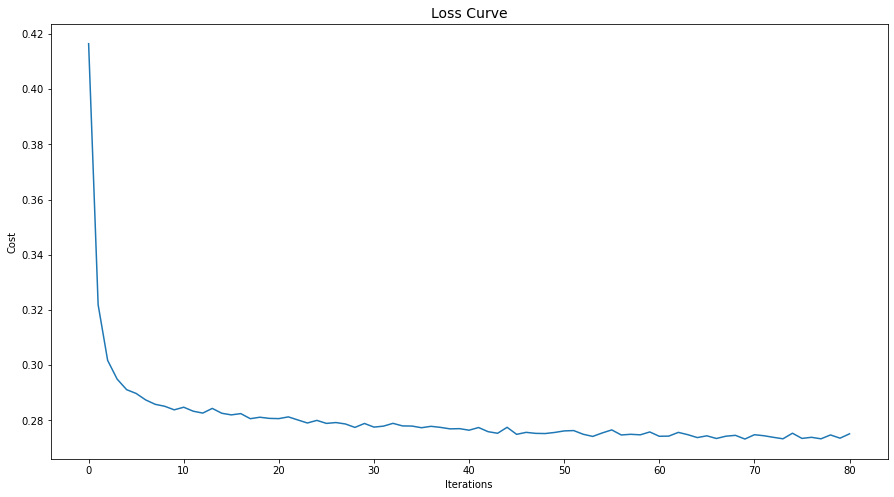

In [95]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()


In [96]:
class2idx = {
    "Ball":0,
    "Innerrace":1,
    "Outerrace":2

}

idx2class = {v: k for k, v in class2idx.items()}

#df['Faults'].replace(class2idx, inplace=True)
#df['Faults'].unique()

In [97]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(testY, y_pred)).rename(columns=idx2class, index=idx2class)
target_names = { k for k, v in class2idx.items()}
f1score = classification_report(testY, y_pred, target_names=target_names)
print(f1score)

              precision    recall  f1-score   support

   Innerrace       0.87      0.70      0.78     36815
        Ball       1.00      1.00      1.00     36564
   Outerrace       0.75      0.90      0.82     36692

    accuracy                           0.87    110071
   macro avg       0.87      0.87      0.86    110071
weighted avg       0.87      0.87      0.86    110071



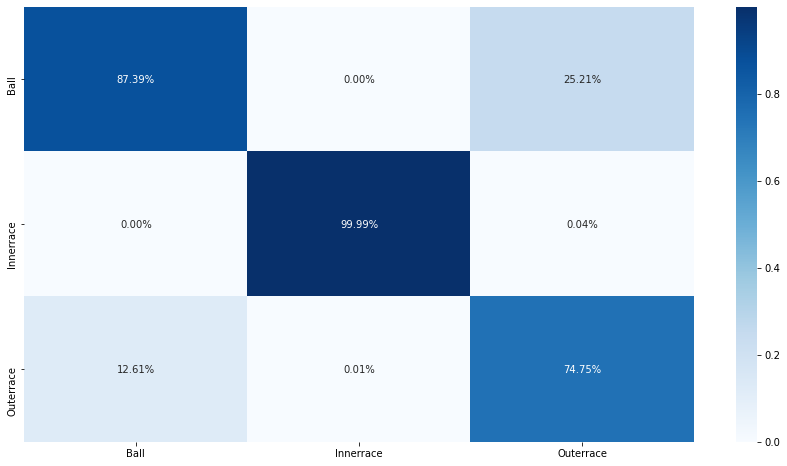

In [98]:
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues')
#plt.title('Confusion Matrix')

#,  ax=axes[0]).set_title('Train-Val Accuracy/Epoch'


plt.savefig(figuredir + "confusion_matrix1.png", bbox_inches='tight', dpi=600)
plt.show()
